# Building an EVI Timeseries with ODC STAC

This tutorial provides an alternate way to work with Harmonized Landsat Sentinel-2 ([HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/)) data using [CMR-STAC](https://cmr.earthdata.nasa.gov/stac/docs/index.html) coupled and [OpenDataCube](https://www.opendatacube.org/), which uses the [dask](https://www.dask.org/) and [xarray](https://xarray.dev/) libraries to build a timeseries of data. `OpenDataCube` leverages the STAC metadata to provide values to `xarray` so that data can be loaded lazily with all of the dimensions, coordinate reference system and other relevant attributes. This information along with the cloud-optimized geotiff format of HLS Data means that only the necessary portions of the files required for the desired operation need to be read. On top of this, `dask` is used for parallelization. This workflow is a much faster alternative to the methods used in the [HLS Tutorial](https://github.com/nasa/HLS-Data-Resources/blob/main/python/tutorials/HLS_Tutorial.ipynb), but uses higher level Python libraries, making the code less adaptable to other use-cases. Using these additional Python libraries requires additional dependencies from other resources in this repository. Please use the [Python Environment Setup](#python-environment-setup) section below to set up a compatible Python environment.

## Python Environment Setup

A compatible python environment can be created by following the [Python Environment setup instructions](https://github.com/nasa/VITALS/blob/main/setup/setup_instructions.md), activating that environment and adding the `pystac-client` and `odc-stac` packages:

```
mamba activate lpdaac_vitals
```

```
mamba install -c conda-forge pystac-client odc-stac dask
```

or if you want to set up a separate environment:

```
mamba create -n hls_odc -c conda-forge --yes python=3.12 fiona gdal hvplot geoviews rioxarray rasterio jupyter geopandas earthaccess jupyter_bokeh scikit-image jupyterlab dask odc-stac pystac-client
```

## Tutorial Use Case

This guide examines changes in enhanced vegetation index ([EVI](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_4.php)) over an agricultural region in northern California, the same as the [HLS Tutorial: Getting Started with Cloud-Native HLS Data in Python](https://github.com/nasa/HLS-Data-Resources/blob/main/python/tutorials/HLS_Tutorial.ipynb). The goal of the project is to observe HLS-derived mean EVI over these regions without downloading the entirety of the HLS source data in a cloud-friendly, efficient way. In this notebook we will extract an EVI timeseries from Harmonized Landsat Sentinel-2 ([HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/)) data. First we will search and find data, then we will lazily load only the necessary subsets of these results directly from the cloud and calculate EVI. 

### Background

The Harmonized Landsat Sentinel-2 ([HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/)) project produces seamless, harmonized surface reflectance data from the Operational Land Imager (OLI) and Multi-Spectral Instrument (MSI) aboard Landsat and Sentinel-2 Earth-observing satellites, respectively. The aim is to produce seamless products with normalized parameters, which include atmospheric correction, cloud and cloud-shadow masking, geographic co-registration and common gridding, normalized bidirectional reflectance distribution function, and spectral band adjustment. This will provide global observation of the Earth’s surface every 2-3 days with 30 meter spatial resolution. One of the major applications that will benefit from HLS is agriculture assessment and monitoring, which is used as the use case for this tutorial.

## Requirements

- A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided.

## Learning Objectives

- How to use CMR-STAC to search for HLS data
- How to open and access data using dask and Open Data Cube.

## Data Used

- Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - [HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)  
    - The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products.  
    - Science Dataset (SDS) layers:  
        - B8A (NIR Narrow)  
        - B04 (Red)  
        - B02 (Blue)   
- Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - [HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)  
    - The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products.  
     - Science Dataset (SDS) layers:  
        - B05 (NIR)  
        - B04 (Red)  
        - B02 (Blue)   

## Tutorial Outline

1. [**Getting Started**](#getstarted)  
    1.1 Import Packages  
    1.2 EarthData Login
    1.3 Set up Dask Client
2. [**Finding HLS Data**](#find)  
3. [**Opening Data with ODC-STAC**](#odcstac)  
    3.1 Apply Scale Factor
4. [**Calculating EVI**](#calcevi)   
5. [**Quality Filtering**](#qualityfilter)  
6. [**Calculating Statistics**](#stats)  

## 1. Getting Started<a id="getstarted"></a>

### 1.1 Import Packages

Import the required packages.

In [1]:
# Load all the libraries
import os
import numpy as np
import dask.distributed
import pystac_client
import geopandas as gpd
import odc.stac
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import earthaccess
import hvplot.xarray

### 1.2 Earthdata Login Authentication

We will use the `earthaccess` package for authentication. `earthaccess` can either create a a new local `.netrc` file to store credentials or validate that one exists already in you user profile. If you do not have a `.netrc` file, you will be prompted for your credentials and one will be created.

In [2]:
# Log into earthaccess - ensures creation of .netrc file
earthaccess.login(persist=True)

### 1.3 Set up Dask Client

Here we set up a local `dask` cluster, which will define tasks based on our lazy loaded data and functions, then split those tasks accross our locally available threads or workers to improve process efficiency. You can view the dashboard by clicking the link and see various dashboards and monitor them as you run future cells.

In [3]:
# Initialize Dask Client
client = dask.distributed.Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60797,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:60814,Total threads: 2
Dashboard: http://127.0.0.1:60821/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:60800,


### 1.4 Configure GDAL Options and rio environment

In [4]:
# Configure odc.stac rio env - requires a .netrc file, sends info to dask client
odc.stac.configure_rio(cloud_defaults=True,
                       verbose=True,
                       client=client,
                       GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                       GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                       GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))

GDAL_DATA                    = /Users/hephzibahadeniji/miniconda3/envs/lpdaac_vitals/share/gdal
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5
GDAL_HTTP_COOKIEFILE         = /Users/hephzibahadeniji/cookies.txt
GDAL_HTTP_COOKIEJAR          = /Users/hephzibahadeniji/cookies.txt


## 2. CMR-STAC Search<a id="find"></a>

To find HLS data, we will use the `pystac_client` python library to search [NASA's Common Metadata Repository SpatioTemporal Asset Catalog (CMR-STAC)](https://cmr.earthdata.nasa.gov/stac/docs/index.html#tag/STAC) for HLS data. We will use a geojson file containing our region of interest (ROI) to search for files that intersect. For this use case, our ROI is an agricultural field in Northern California.

In [5]:
# Open ROI polygon
roi = gpd.read_file('../../data/Field_Boundary.geojson')

Add the collection, datetime range, results limit, and simplify our ROI to a bounding box and store these as search parameters. After defining these, conduct a stac search using the `LPCLOUD` STAC endpoint and return our query as a list of items.

In [6]:
catalog = pystac_client.Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")
# Define search parameters
search_params = {
    "collections": ["HLSS30_2.0","HLSL30_2.0"],
    "bbox": tuple(list(roi.total_bounds)),
    "datetime": "2021-05-01/2021-09-30",
    "limit": 100,
}
# Perform the search
query = catalog.search(**search_params)
items = query.items()

In [7]:
items = list(query.items())
print(f"Found: {len(items):d} granules")

Found: 78 granules


We can preview what these results look like.

In [8]:
items[0]

<Item id=HLS.S30.T10TEK.2021122T185911.v2.0>

In [9]:
items[3]

<Item id=HLS.L30.T10TEK.2021128T184447.v2.0>

To stack the data from both Landsat and Sentinel instruments, we need common band names for HLSL30 B5 (NIR) and HLSS30 B8A (NIR). We can simply rename them NIR in the stac results.

In [10]:
# Rename HLSS B8A and HLSL B05 to common band name
for item in items:
    if "HLS.L30" in item.id:
        item.assets["NIR"] = item.assets.pop("B05")
    if "HLS.S30" in item.id:
        item.assets["NIR"] = item.assets.pop("B8A")


In [11]:
# Confirm this changed the stac results
items[0]

<Item id=HLS.S30.T10TEK.2021122T185911.v2.0>

## 3. Opening Data with ODC-STAC<a id="odcstac"></a>

Use the `odc.stac.stac_load` function to load the data from the STAC results lazily into a dataset. To do this, we must provide a crs, a list of STAC results, a tuple of the bands we want to load, an expected resolution, and a dask chunk size.

In [12]:
# Set CRS and resolution, open lazily with odc.stac
crs = "utm"
ds = odc.stac.stac_load(
    items,
    bands=("B02", "B04","NIR", "Fmask"),
    crs=crs,
    resolution=30,
    chunks={"band":1,"x":512,"y":512},  # If empty, chunks along band dim, 
    #groupby="solar_day", # This limits to first obs per day
)
display(ds)

<xarray.Dataset> Size: 17GB
Dimensions:      (y: 3667, x: 3661, time: 78)
Coordinates:
  * y            (y) float64 29kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
  * x            (x) float64 29kB 5e+05 5e+05 5.001e+05 ... 6.098e+05 6.098e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 624B 2021-05-02T19:13:19.930000 ... 20...
Data variables:
    B02          (time, y, x) float32 4GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B04          (time, y, x) float32 4GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    NIR          (time, y, x) float32 4GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    Fmask        (time, y, x) float32 4GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

We can preview the size and shapes of the data we have loaded using the `geobox` function.

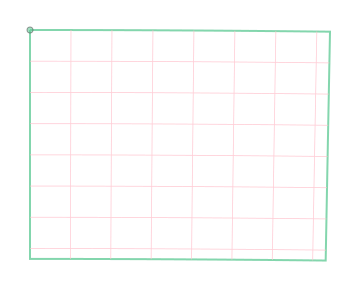

In [13]:
# Show Geobox
ds.odc.geobox

Next, we will clip the data to our ROI using the `rio.clip` function. This will continue to work lazily on the data, so we have yet to actually load any data.

In [14]:
# Clip
ds = ds.rio.clip(roi.geometry.values, roi.crs, all_touched=True)

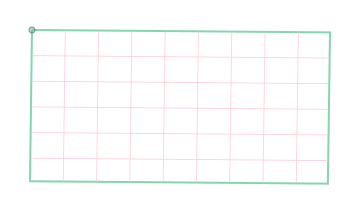

In [15]:
# Show Clipped Geobox
ds.odc.geobox

The `scale_factor` information in some of the HLSL30 granules are found in the file metadata, but missing from the Band metadata, meaning this isn't applied automatically. Manually scale each of the data arrays by the scale factor.

In [16]:
# Scale the data
ds.NIR.data = 0.0001 * ds.NIR.data
ds.B04.data = 0.0001 * ds.B04.data
ds.B02.data = 0.0001 * ds.B02.data

Now that we have clipped and scaled our data, we can load the minimal subset of data we need to calculate our EVI over our time period of interest.

In [17]:
ds.load()

/Users/hephzibahadeniji/miniconda3/envs/lpdaac_vitals/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.17 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.Dataset> Size: 26MB
Dimensions:      (y: 118, x: 179, time: 78)
Coordinates:
  * y            (y) float64 944B 4.42e+06 4.42e+06 ... 4.416e+06 4.416e+06
  * x            (x) float64 1kB 5.772e+05 5.772e+05 ... 5.825e+05 5.825e+05
  * time         (time) datetime64[ns] 624B 2021-05-02T19:13:19.930000 ... 20...
    spatial_ref  int64 8B 0
Data variables:
    B02          (time, y, x) float32 7MB nan nan nan nan ... nan nan nan nan
    B04          (time, y, x) float32 7MB nan nan nan nan ... nan nan nan nan
    NIR          (time, y, x) float32 7MB nan nan nan nan ... nan nan nan nan
    Fmask        (time, y, x) float32 7MB nan nan nan nan ... nan nan nan nan

Plot the NIR data to ensure our scaling and clipping worked as expected. We can use the slide bar to scroll through the time dimension showing the 

In [18]:
# Plot to ensure scaling worked
ds.NIR.hvplot.image(x="x", y="y", groupby="time", cmap="viridis", width=600, height=500, crs='EPSG:32610', tiles='ESRI', rasterize=True)

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (NIR)

## 4. Calculate EVI<a id="calcevi"></a>

Now we can build an Enhanced Vegetation Index (EVI) dataset using the EVI formula:

$$
\text{EVI} = G \cdot \frac{\text{NIR} - \text{Red}}{\text{NIR} + C_1 \cdot \text{Red} - C_2 \cdot \text{Blue} + L}
$$

**NIR**: Near-Infrared reflectance.  
**Red**: Reflectance in the red band.  
**Blue**: Reflectance in the blue band, used primarily to correct for aerosol influences.  
**G**: Gain factor (often set to 2.5) that scales the index.  
**C₁**: Coefficient for the aerosol resistance term using the red band (commonly 6).  
**C₂**: Coefficient for the aerosol resistance term using the blue band (commonly 7.5).  
**L**: Canopy background adjustment, which helps to minimize soil brightness influences (commonly 1).  

We will use the typical values adopted for the MODIS algorithm for G, C1, C2 and L. The output values will range from -1 to 1 and indicate strength of vegetation signal, which correlates with biomass.

In [19]:
# Calculate EVI
evi_ds = 2.5 * ((ds.NIR - ds.B04) / (ds.NIR + 6.0 * ds.B04 - 7.5 * ds.B02 + 1.0))

In [20]:
evi_ds = evi_ds.compute()

Now lets visualize our EVI over our ROI. We can scroll through the time-series using the slider bar to the right of the figure.

In [21]:
evi_ds.hvplot.image(x="x", y="y", groupby="time", cmap="YlGn", clim=(0, 1), crs='EPSG:32610', tiles='ESRI', rasterize=True)

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)

## 5. Quality Masking<a id="qualityfilter"></a>

Lastly, we will apply a function to our EVI dataset, which will mask out pixels based on our bit selection. 

For HLS v2.0 products, all quality information is included in the Fmask layer. This layer includes values corresponding to combinations of bits that represent
different quality descriptions at each location within the scene.  Bits are ordered `76543210` and correspond to the following quality descriptions:  

|Bit Number|Mask Name|Bit Value|Description|
|---|---|---|---|
|7-6|Aerosol<br>Level|11<br>10<br>01<br>00|High<br>Medium<br>Low<br>Clear<br>|
|5|Water|1<br>0|Yes<br>No|
|4|Snow/Ice|1<br>0|Yes<br>No|
|3|Cloud<br>Shadow|1<br>0|Yes<br>No|
|2|Cloud/Shadow<br>Adjacent|1<br>0|Yes<br>No|
|1|Cloud|1<br>0|Yes<br>No|
|0|Cirrus|Reserved|NA|

For example, an 8bit integer 224 converted to binary is 11100000. This would indicate high aerosol (bits 7-6), and water (bit 5) are present in a pixel with that value.

In [22]:
def create_quality_mask(quality_data, bit_nums: list = [1, 2, 3, 4, 5]):
    """
    Uses the Fmask layer and bit numbers to create a binary mask of good pixels.
    By default, bits 1-5 are used.
    """
    mask_array = np.zeros((quality_data.shape[0], quality_data.shape[1]))
    # Remove/Mask Fill Values and Convert to Integer
    quality_data = np.nan_to_num(quality_data.copy(), nan=255).astype(np.int8)
    for bit in bit_nums:
        # Create a Single Binary Mask Layer
        mask_temp = np.array(quality_data) & 1 << bit > 0
        mask_array = np.logical_or(mask_array, mask_temp)
    return mask_array

Use xarray's `apply_ufunc` to apply a function in a vectorized way to our EVI timeseries dataset. `bit_nums` can be provided as a dict to specify which bits to mask out.

In [23]:
quality_mask = xr.apply_ufunc(
    create_quality_mask,
    ds.Fmask,
    kwargs={"bit_nums": [1,2,3,4,5]},
    input_core_dims=[["x", "y"]],
    output_core_dims=[["x", "y"]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.bool],
)

Now use the `where` function to mask out regions corresponding with the bit numbers and visualize the EVI timeseries again.

In [24]:
evi_ds.where(~quality_mask).hvplot.image(x="x", y="y", groupby="time", cmap="YlGn", clim=(0, 1), crs='EPSG:32610', tiles='ESRI', rasterize=True)

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)

In [29]:
#Convert to Raster

import xarray as xr
import pandas as pd
import os

# Step 1: Group by month and compute monthly mean
monthly_evi = evi_ds.groupby("time.month").mean(dim="time", skipna=True)

# Optional: Give the DataArray a name for export
monthly_evi.name = "EVI"

# Set spatial dimensions and CRS if not already set
monthly_evi.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
monthly_evi.rio.write_crs("EPSG:32610", inplace=True)  # adjust if your CRS is different

# Step 2: Export each month as a separate raster
output_dir = "monthly_evi_rasters"
os.makedirs(output_dir, exist_ok=True)

for month in monthly_evi.month.values:
    evi_month = monthly_evi.sel(month=month)
    output_path = os.path.join(output_dir, f"EVI_month_{month:02d}.tif")
    evi_month.rio.to_raster(output_path)
    print(f"Exported: {output_path}")


Exported: monthly_evi_rasters/EVI_month_05.tif
Exported: monthly_evi_rasters/EVI_month_06.tif
Exported: monthly_evi_rasters/EVI_month_07.tif
Exported: monthly_evi_rasters/EVI_month_08.tif
Exported: monthly_evi_rasters/EVI_month_09.tif


In [31]:
#Plot 
evi_month = rxr.open_rasterio("monthly_evi_rasters/EVI_month_06.tif", masked=True)

# Plot using hvplot (interactive)
evi_month.squeeze().hvplot.image(
    x="x", y="y", cmap="YlGn", title="Monthly Mean EVI - June",
    frame_width=600, frame_height=500, tiles='ESRI'
)

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Image.I :Image   [x,y]   (EVI)

In [32]:


# Load and prepare
evi_may = rxr.open_rasterio("monthly_evi_rasters/EVI_month_05.tif", masked=True).squeeze()
evi_june = rxr.open_rasterio("monthly_evi_rasters/EVI_month_06.tif", masked=True).squeeze()

# Plot with linked extents
may_plot = evi_may.hvplot.image(
    x='x', y='y', cmap='YlGn', clim=(0, 1), tiles='ESRI',
    frame_width=400, frame_height=400, title='EVI - May'
)

june_plot = evi_june.hvplot.image(
    x='x', y='y', cmap='YlGn', clim=(0, 1), tiles='ESRI',
    frame_width=400, frame_height=400, title='EVI - June'
)

# Show side-by-side
may_plot + june_plot


:Layout
   .Overlay.I  :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x,y]   (EVI)
   .Overlay.II :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x,y]   (EVI)

In [ ]:
##Convert to CSV

In [25]:
print(evi_ds)

<xarray.DataArray (time: 78, y: 118, x: 179)> Size: 7MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, n

In [26]:
##Test CSV export
# Flatten dataset into a DataFrame
df = evi_ds.to_dataframe(name="EVI").reset_index()

# Drop rows with NaN values (e.g., masked/cloudy pixels)
df = df.dropna(subset=["EVI"])

# Optional: round values and keep only needed columns
df["EVI"] = df["EVI"].round(4)
df = df[["time", "x", "y", "EVI"]]

# Save to CSV
df.to_csv("evi_timeseries.csv", index=False)


In [27]:
##Test CSV export with long and lat

# Step 1: Flatten xarray EVI dataset to a DataFrame
df = evi_ds.to_dataframe(name="EVI").reset_index()

# Step 2: Drop rows with missing EVI (e.g., masked pixels)
df = df.dropna(subset=["EVI"])

# Step 3: Convert (x, y) in UTM to lat/lon
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.x, df.y),
    crs="EPSG:32610"  # Replace with your dataset's CRS if different
)

# Reproject to WGS84 (lat/lon)
gdf = gdf.to_crs("EPSG:4326")

# Step 4: Add lat/lon columns
gdf["lon"] = gdf.geometry.x
gdf["lat"] = gdf.geometry.y

# Step 5: Drop unneeded columns and geometry
gdf = gdf.drop(columns=["x", "y", "geometry"])

# Optional: round values for compact output
gdf["EVI"] = gdf["EVI"].round(4)
gdf["lat"] = gdf["lat"].round(6)
gdf["lon"] = gdf["lon"].round(6)

# Step 6: Export to CSV
gdf.to_csv("evi_timeseries_latlon.csv", index=False)


In [28]:
##Plot CSV with long and lat

import pandas as pd
import geopandas as gpd
import hvplot.pandas  # enables hvplot on GeoDataFrames

# Load CSV
df = pd.read_csv("evi_timeseries_latlon.csv")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

# Plot with hvPlot: group by time to animate
gdf.hvplot.points(
    x="lon",
    y="lat",
    geo=True,
    groupby="time",
    color="EVI",
    cmap="YlGn",
    tiles="ESRI",
    size=5,
    frame_width=700,
    frame_height=500,
    clim=(0, 1),
    title="EVI by Coordinate and Time"
)


:DynamicMap   [time]
   :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [lon,lat]   (EVI)

## Contact Info  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 